In [142]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from src.data_cleansing import load_codified_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV

In [143]:
data=load_codified_data("train")
X,y=data.drop(columns="price"),data["price"]
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=3000,train_size=0.8)

We are going to try the Extra Trees Regressor model

In [145]:
etr=ExtraTreesRegressor()

etr.fit(X_train,y_train)

y_predict=etr.predict(X_test)

RMSE=mean_squared_error(y_test,y_predict)**0.5

R2=r2_score(y_test,y_predict)

print(f"R2={R2}, RMSE={RMSE}")

R2=0.9811902572493904, RMSE=539.9753823097732


In [ ]:
We are going to optimize this results by optimizing the hyperparameters of the model

In [146]:

params={"n_estimators":[100,150,250],
        "max_depth":[10,25,50],
        "min_samples_split":[5,10,20]
       }
GSCV=GridSearchCV(estimator=ExtraTreesRegressor(n_estimators=200,max_depth=50,min_samples_split=10,min_samples_leaf=1,random_state=300),
             scoring="neg_root_mean_squared_error",verbose=1,n_jobs=-1,param_grid=params,cv=5)

GSCV.fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  2.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                           criterion='mse', max_depth=50,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=10,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=200, n_jobs=None,
                                           oob_score=False, random_state=300,
                                           verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_g

In [147]:
y_test_predict_opt=GSCV.predict(X_test)

RMSE=mean_squared_error(y_test,y_test_predict_opt)**0.5

R2=r2_score(y_test,y_test_predict_opt)

print(f"R2={R2}, RMSE={RMSE}")

R2=0.9824155552340804, RMSE=522.0917883937105


Those results are a little improve compared with the model wothout optimization, so we are going to train the model with the whole dataset

In [151]:
etr_optimized=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                           criterion='mse', max_depth=50,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=10,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=200, n_jobs=-1,
                                           oob_score=False, random_state=300,
                                           verbose=0, warm_start=False)

etr_optimized.fit(X,y)
test_data_unknown=load_codified_data("test")

Y_PREDICTED=etr_optimized.predict(test_data_unknown)

pd.DataFrame(Y_PREDICTED,columns=["price"]).to_csv("output/etr_optimized.csv",index_label="id")

With this parameter we reached a (public) RMSE of: 522.89916 in the competition. At the moment this is written, is the best value reached. We are trying to improve it.

We can see that data have a clear dependency with the clarity of the diamond, so we are going to improve our results in this basis

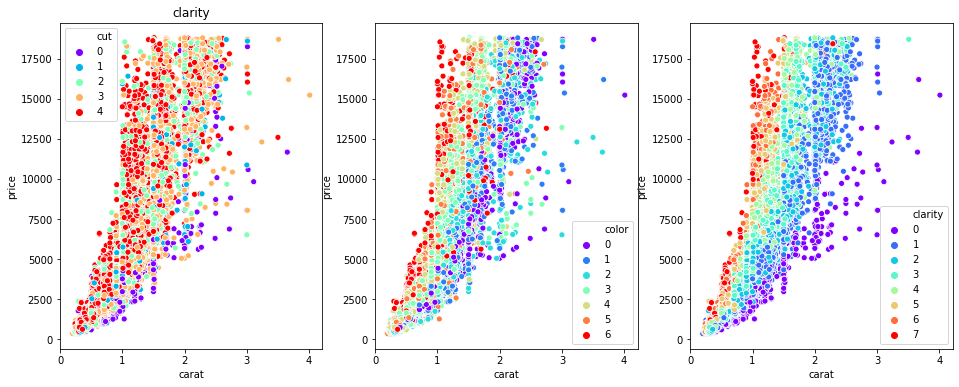

In [41]:
fig, axis=plt.subplots(1,3,figsize=(16,6))

axis[0].set_title("cut")
axis[0].set_title("color")
axis[0].set_title("clarity")
sns.scatterplot(x="carat",y="price",hue="cut",data=data,ax=axis[0],palette="rainbow", legend="full")
sns.scatterplot(x="carat",y="price",hue="color",data=data,ax=axis[1],palette="rainbow", legend="full")
sns.scatterplot(x="carat",y="price",hue="clarity",data=data,ax=axis[2],palette="rainbow", legend="full")

We want to see how the model performance for each clarity level

In [152]:
for i in range(8):
    y_pred=etr_optimized.predict(X_test[X_test.clarity==i])
    RMSE=mean_squared_error(y_pred,y_test[X_test.clarity==i])**0.5
    print(f"clarity level: {i}, RMSE: {RMSE}")

clarity level: 0, RMSE: 436.9172190668345
clarity level: 1, RMSE: 408.2604256041021
clarity level: 2, RMSE: 295.89259568495845
clarity level: 3, RMSE: 253.0857365598965
clarity level: 4, RMSE: 222.02154854864565
clarity level: 5, RMSE: 241.21259316127998
clarity level: 6, RMSE: 202.07940611404575
clarity level: 7, RMSE: 233.75279650936284


Our aproach it's going to be create 8 different models, train then with the data of one transparency level and then git its hyperparameters to perform best for the 8 different transparency levels

In [153]:
clarity_models={i:ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                           criterion='mse', max_depth=50,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=10,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=200, n_jobs=-1,
                                           oob_score=False, random_state=300,
                                           verbose=0, warm_start=False) for i in data.clarity.unique()}

for k,v in clarity_models.items():
    v.fit(X_train[X_train.clarity==k],y_train[X_train.clarity==k])

In [172]:
y_predict=pd.DataFrame(columns=["price"])

for index in X_test.index:
    
    prediction=clarity_models[int(X_test.loc[index].clarity)].predict(np.asarray(X_test.loc[index]).reshape(1,-1))
    y_pred=pd.DataFrame(data=prediction,index=[index],columns=["price"])
    y_predict=y_predict.append(y_pred)


In [173]:
RMSE=mean_squared_error(y_test,y_predict)**0.5

R2=r2_score(y_test,y_predict)

print(f"R2={R2}, RMSE={RMSE}")


R2=0.9818461200061043, RMSE=530.4778597572064


In [187]:
y_predict.price

26847     4278.729732
8114       644.628488
8471      1629.195444
18374      535.188135
20421      693.389950
             ...     
21283     2159.515500
1768       850.949550
4362      2837.175972
18281      665.673978
34167    10177.583788
Name: price, Length: 8066, dtype: float64

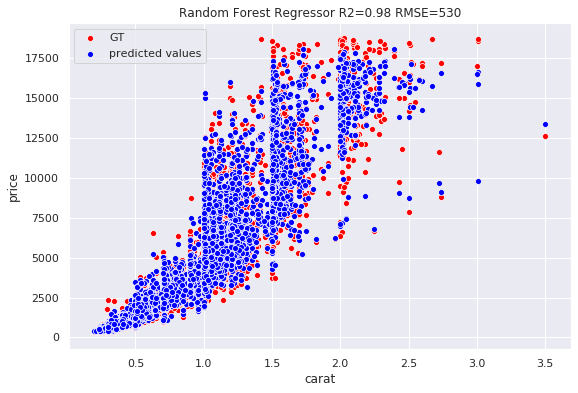

In [198]:
sns.set_style('darkgrid', {'legend.frameon':True})
fig, axis=plt.subplots(1,1,figsize=(9,6))
sns.scatterplot(x=X_test.carat,y=y_test,color="red",label="GT")
axis.set_title("Random Forest Regressor R2=0.98 RMSE=530")

sns.scatterplot(x=X_test.carat,y=y_predict.price,color="blue",label="predicted values")

In [199]:
fig.savefig("output/ETR_prediction.png",transparent=True)

In [ ]:
test_data_unknown=load_codified_data("test")
y_predict=pd.DataFrame(columns=["predict"])
for index in test_data_unknown.index:
    prediction=clarity_models[int(test_data_unknown.loc[index].clarity)].predict(np.asarray(test_data_unknown.loc[index]).reshape(1,-1))
    y_pred=pd.DataFrame(data=prediction,index=[index],columns=["price"])
    y_predict=y_predict.append(y_pred)
    
pd.DataFrame(y_predict,columns=["price"]).to_csv("output/etr-8mo-nohyper.csv",index_label="id")

With this model we obtain RMSE= 522.39263 in the competition.

We could try the optimize the hyperparameters for each separate model (Sadly, no automatization can be done here), but doesn't seems to worth the effort.